# CLASSIFICATION: UNCLASSIFIED

## Background

There are a few factors that can make analyzing data more difficult. The most obvious, and probably most discussed, aspect is the volume of data, typically referring to the number of entities or data points that need to be analyzed. However, the complexity of the data is also very important.

In order to use most machine learning algorithms (especially those outside the "deep learning" realm), data needs to be fairly well structured: $n$ data points with $p$ numerical features. Some examples of this are: 
* a database table with $p$ columns 
* an image where each pixel is represented by one feature, so that a 30 x 30 image is represented by $p=900$ features
* a text document where we count occurences of each word, so $p$ is the number of unique words seen.

$p$, the number of features, is often referred to as the dimensionality of the data. As data becomes more complex, the numerical representation of it often increases in dimension which leads to the "curse of dimensionality". This refers to the tendency of higher dimensional data to be much sparser (e.g. many zeros) and much harder to analyze or do machine learning on. 

Thus, a necessary step for machine learning on high dimensional data is dimension reduction. Dimension reduction can be done either by choosing a subset of features (feature selection) or by combining features into a smaller number of new features (feature extraction). We will focus on the latter.

There are many methods of dimensionality reduction with varying degrees of effectiveness and speed. They all generally follow the same paradigm - we have some attribute in our higher dimensional space that we wish to preserve in our lower dimensional state and we want to maximize this preservation. The attributes we are preserving and how to the maximization is done are the differences in each algorithm.

We will first load some high-dimensional data and show the 64-dimensional representation of the 8x8 image

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

(1797, 64)


[[  0.   0.   5. ...,   0.   0.   0.]
 [  0.   0.   0. ...,  10.   0.   0.]
 [  0.   0.   0. ...,  16.   9.   0.]
 ..., 
 [  0.   0.   1. ...,   6.   0.   0.]
 [  0.   0.   2. ...,  12.   0.   0.]
 [  0.   0.  10. ...,  12.   1.   0.]]


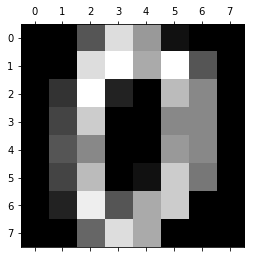

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
X = digits.data
print(digits.data)
plt.gray()
plt.matshow(digits.images[0])
plt.show()

## PCA

One of the simplest and fastest dimension reduction method is PCA. PCA uses some linear algebra techniques to transform the input matrix into another matrix of the same shape who columns are linearly uncorrelated. More importantly, the columns of this matrix ordered such that the first column explains the most variance and the amoung of variance explained decreases with each column. Thus, to reduce the dimension, one can take the first $k$ columns of this matrix.

In the example below, we will apply PCA to the data and examine variance explained, as a percentage, of each column.

PCA exists in the sklearn package which is a standard way of using most of its techniques. The general steps are:
* initialize the object for the technique 
* fit the model with the data
* transform/predict the data

The last two steps can be merged with a fit_transform or fit_transform call

In [3]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
pca.fit(X)
print(np.round(pca.explained_variance_ratio_,3))

[ 0.149  0.136  0.118  0.084  0.058  0.049  0.043  0.037  0.034  0.031
  0.024  0.023  0.018  0.018  0.015  0.014  0.013  0.012  0.01   0.009
  0.009  0.008  0.008  0.007  0.007  0.006  0.006  0.005  0.005  0.004
  0.004  0.004  0.003  0.003  0.003  0.003  0.003  0.002  0.002  0.002
  0.002  0.002  0.002  0.001  0.001  0.001  0.001  0.001  0.001  0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.   ]


It might be helpful to also look at the running sum. So, in this case the first 10 columns explain 73.8% of the variance in the data.  How we choose $k$ depends on a tradeoff between the goals of reducing dimension and not losing useful information. If we wanted to focus more on the former, we could choose $k=10$, for example. If we really didn't want to lose much information, we could use $k=30$ which would still explain 96% of variance in the data. This decision often depends on what we intended to do next with the data.

In [4]:
print(np.round(np.cumsum(pca.explained_variance_ratio_),3))

[ 0.149  0.285  0.403  0.487  0.545  0.594  0.637  0.674  0.707  0.738
  0.762  0.785  0.803  0.821  0.835  0.849  0.863  0.875  0.885  0.894
  0.903  0.911  0.919  0.926  0.933  0.939  0.945  0.95   0.955  0.959
  0.963  0.966  0.97   0.973  0.976  0.979  0.982  0.984  0.986  0.988
  0.99   0.992  0.993  0.995  0.996  0.997  0.998  0.999  0.999  1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
  1.     1.   ]


In [5]:
Xnew = pca.transform(X)[:,:10] #transform data based on our model

In [6]:
Xnew = PCA(n_components=10).fit_transform(X) #same as doing this

We can see what the benefit of this is by plotting the first two columns of our new matrix, coloured with the label of the digit. Here, it does a decent job of seperating some of the classes 

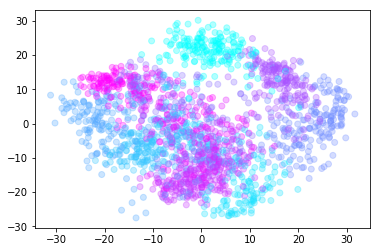

In [7]:
plt.cool()
plt.scatter(Xnew[:,0], Xnew[:,1], c=digits.target, alpha=0.3)

## Truncated SVD for Sparse Data

PCA is a very robust technique that will work for many types of data. One feature of the method is that it will "center" the data before transforming (e.g. ensure each column has mean 0 and stadard deviation 1). This is useful for many reasons but can be a problem when dealing with sparse data. 

We consider data "sparse" if it has many zero entries. For example, the digit data we are working for is quite sparse - about half the entries are zero. Sparsity will tend to arise when we convert complex data into feature vectors. For example, if we are counting word occurences, a given document will likely have 0 occurences of most words in the globably vocabulary. While this sparsity makes analysis harder and necessitates dimension reduction, it can be very beneficial computationally. We can use sparse linear algebra libraries which work by only keep track of non-zero entries which means less data in memory and fewer operations to perform. 

Going back to PCA, if we centre the columns then we destroy sparsity. For example, if a column has mean 2, when we will subtract 2 from each value in the centering process and all of the zero values will become -2, meaning the column is no longer sparse. We can work around this in python by using Truncated SVD which is one of the few methods that can accept sparse data.

Below, we convert our data to a sparse matrix and use Truncated SVD to reduce the dimension.

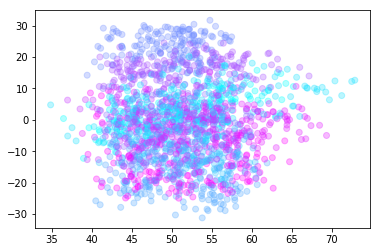

In [8]:
import scipy
X_sparse = scipy.sparse.csr_matrix(X)

from sklearn.decomposition import TruncatedSVD
Xnew_svd = TruncatedSVD(n_components=10, n_iter=40).fit_transform(X_sparse)

plt.scatter(Xnew_svd[:,0], Xnew_svd[:,1], c=digits.target, alpha=0.3)

It does not do as well, at least in the first two dimensions compared to PCA, so it is important to consider the tradeoff. However, there may be cases where it is simply infeasible to convert your sparse data into a dense matrix in order to use PCA.

## t-SNE and LDA

t-SNE is a powerful dimension reduction technique. It has limitations in terms of scalability but works very well when it can run. See the notebook on t-SNE.

It was mentioned before that sparse high-dimensional data often arises from text, in the form of term-frequency matrices (counting the number of times a word is seen in each document). There are specialized techniques to deal with text data, such as LDA. See the notebook on Text Analysis

## GLRMs

In the intro, it was mentioned that machine learning techniques often require structured numerical data and that converting data to this form can greatly increase the number of dimensions. But another problem can arise when the data is structured and mostly numerical, but the column types are heterogenous. Consider a database table with columns:
* age, height, weight (numerical)
* sex, official language preference (binary)
* province (categorical), job category (categorial with many categories)
* education level (ordinal, meaning categories that have a natural order)

We could easily turn all of this data into a numerical matrix by converting the categories to binary indicators (e.g. each province would have its own column and would be either 1 or 0) and ordinal values into numbers. However, this ignores the underlying structure of each feature. An alternate approach is to apply dimension reduction while staying true to the original data types.

Additionally, data is sometimes missing - we may not know a particular "cell" in our data table. Many methods would fail at handling this situation.

There is a family of algorithms that can handle both mixed data types and missing data known as Generalized Low Rank Models (GLRMs). GLRMs are a family of dimension reduction techniques. Without going into the details the main idea is to start with your data matrix $D$ which can have varying data types and missing data. We wish to find two matrices $X$ and $Y$ such that $XY$ is as close to $D$ as possible, where "close" is defined differently for varying data types. The dimension of $X$ is chosen to be small so that $X$ is a lower dimensional representation of our data.

This is implemented in python using the h2o library.


# Configuration

To get  h2o to work on JOVE you must install h2o. h2o was not installed by default because it depends on Java and makes the environment much larger, but it can be instlaled easily if required. Open up a new terminal (from the JOVE File manager New -> Terminal) and run these two commands:

```{bash}
conda install h2o
pip install h2o
```

In [12]:
import h2o
import csv
import time
import numpy as np
import matplotlib.pyplot as plt
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

h2o.init(nthreads=8)  

/mypath/lib/python3.6/site-packages/h2o/backend/connection.py:312: UserWarning: Proxy is defined in the environment: http_proxy. This may interfere with your H2O Connection.
  "This may interfere with your H2O Connection." % name)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,21 secs
H2O cluster version:,3.10.4.8
H2O cluster version age:,2 months and 23 days
H2O cluster name:,H2O_from_python_mpfrane_m3ffao
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [13]:
#generate some sample data
#10K rows, 20 continuous features, 10 binary, 10 ordinal, 10 categorical
import sys
sys.path.insert(0,"../Various/")
import make_sample_data
data, data_types = make_sample_data.generate_sample_data(10000, 20, 10, 10,10, 15, 5, 3, 0.10, 0.10)

In [14]:
colnames = [data_types[i] + "_" + str(i) for i in range(len(data_types ))]
h2o_data = h2o.H2OFrame(python_obj=data, column_names = colnames)

for cc in colnames:
    if 'binary' in cc or 'categorical' in cc or 'oridinal' in cc:
        h2o_data[cc] = h2o_data[cc].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [15]:
glrm = h2o.estimators.glrm.H2OGeneralizedLowRankEstimator(k=10, loss='Quadratic', init = 'svd', transform='STANDARDIZE',regularization_x='Quadratic', regularization_y='Quadratic', gamma_x=1.0, gamma_y=1.0)
glrm.train(x=colnames, training_frame=h2o_data)

glrm Model Build progress: |██████████████████████████████████████████████| 100%


In [16]:
X = h2o.get_frame(glrm._model_json['output']['representation_name'])  
X = np.array(X.as_data_frame())#[1:,:]

Y = np.array(glrm.archetypes()) #get back Y where binary and categorical columns are expanded

In [17]:
X.shape

(10000, 10)